<a href="https://colab.research.google.com/github/AbinayaVina1/DamagedCarParts/blob/main/DamagedCarPartDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


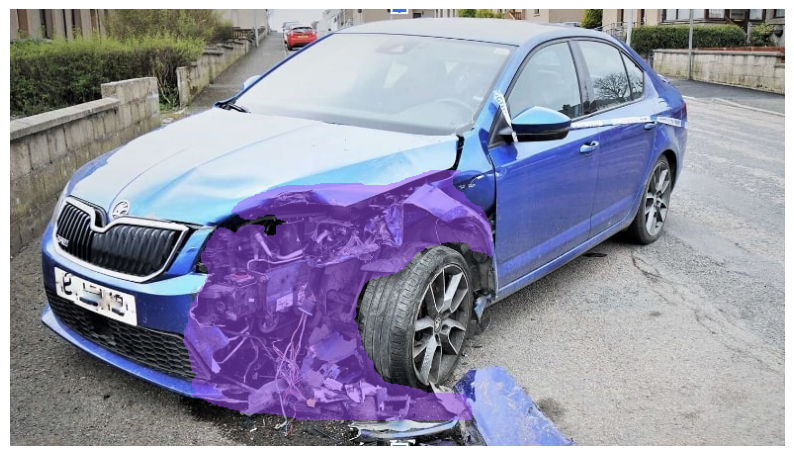

The parts of the car with probable damages are:
wheel
hood


In [ ]:
from roboflow import Roboflow
import supervision as sv
import cv2
import tempfile
import os

# Load the Roboflow API and authenticate with your API key
rf = Roboflow(api_key="z6vwzz9IpEjtAHI4w5FO")

# Load the project for identifying parts of the car
project_parts = rf.workspace().project("car-parts-segmentation")
model_parts = project_parts.version(2).model

# Load the project for detecting damaged areas of the car
project_damage = rf.workspace().project("car-damage-detection-ha5mm")
model_damage = project_damage.version(1).model

# Path to the input image
img_path = "/content/Screenshot 2024-03-06 at 4.14.27 PM.jpg"

# Run the models on the input image
result_damage = model_damage.predict(img_path, confidence=40).json()

# Extract labels and detections from the results
labels_damage = [item["class"] for item in result_damage["predictions"]]
detections_damage = sv.Detections.from_inference(result_damage)

# Extract coordinates of the damaged area
coordinates = []
for List_Coordinates in detections_damage.xyxy:
    for item in List_Coordinates:
        item = int(item)  # Convert to integer
        coordinates.append(item)

# Unpack coordinates
x1, y1, x2, y2 = coordinates

# Initialize label and mask annotators
label_annotator = sv.LabelAnnotator(text_scale=0.15)
mask_annotator = sv.MaskAnnotator()

# Read the input image
image = cv2.imread(img_path)

# Annotate damaged areas of the car
annotated_image_damage = mask_annotator.annotate(
    scene=image, detections=detections_damage)

# Display the annotated damaged areas image
sv.plot_image(image=annotated_image_damage, size=(10, 10))

# Crop the damaged area from the original image
annotated_image_damage = annotated_image_damage[y1:y2, x1:x2]

# Create a temporary directory and save the cropped damaged area
temp_dir = tempfile.mkdtemp()
damage_detect_img = os.path.join(temp_dir, "damage_image.png")
cv2.imwrite(damage_detect_img, annotated_image_damage)

# Run the parts detection model on the cropped damaged area
result_parts = model_parts.predict(damage_detect_img, confidence=15).json()
labels_parts = [item["class"] for item in result_parts["predictions"]]
detections_parts = sv.Detections.from_inference(result_parts)

# Read the damaged area image
damage_img = cv2.imread(damage_detect_img)

# Annotate all car parts on the damaged area image
annotated_image_parts = label_annotator.annotate(
    scene=damage_img, detections=detections_parts, labels=labels_parts)

# Print the parts of the car with probable damages
print("The parts of the car with probable damages are:")
for label in labels_parts:
    print(label)

# Remove the temporary files
os.remove(damage_detect_img)
os.rmdir(temp_dir)